# Image Analysis of Slide 992, the relapse biopsy
**Goal:**  Phenotype cells, explore dataset    
**Input:** 992 dataset quantification as adata object    
**Output:** phenotype geojsons (seg mask and voronoi), processed and filtered adata     
**Author:** Jose Nimo    
**Date_of_creation:** 15.01.2025     
**Date_of_latest_modification:** 10.04.2025    
**Status:** In Progress

# Setup and imports

In [1]:
import os,sys,time
from loguru import logger 

# import scimap as sm # tifffile is an issue it seems

import numpy as np
import pandas as pd
import pandas.api.types as ptypes
import shapely
import geopandas as gpd
import anndata as ad

import pyarrow
import ast
import json

import matplotlib.pyplot as plt
import seaborn as sns

import skimage.io

#custom functions
sys.path.append(os.path.abspath('/Users/jnimoca/Jose_BI/1_Pipelines/openDVP/src/'))
from opendvp import anndata_utils
from opendvp import filtering
from opendvp import imaging
import importlib

for package in [np,pd,gpd,ad]:
    print(f"{package.__name__} {package.__version__}")

def get_datetime():
    return time.strftime("%Y%m%d_%H%M")
get_datetime()    

numpy 1.26.4
pandas 2.2.2
geopandas 1.0.1
anndata 0.11.3


'20250410_0859'

In [3]:
path_to_quant = "/Volumes/Extreme SSD/P26_BCCN/P26E07_E08_E09_SOPA_Gates/quantification/992.csv"
path_to_artefact_annotations = "/Volumes/Extreme SSD/P26_BCCN/P26E10_E11_ImageAnalysis/data/geojsons/QuPath_annotations_for_analysis/992.geojson"
path_to_gates = "/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/data/phenotyping/gates/20241002_1436_992_gates_final.csv"
path_to_phenotype_matrix = "/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/data/phenotyping/phenotype_matrix/20240905_PhenotypeMatrix_v3.csv"

In [4]:
#backup those files for replication
path_to_backup = "/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/data/perSample/992/input_files/"
os.makedirs(path_to_backup, exist_ok=True)

import shutil
for path in  [path_to_quant, path_to_artefact_annotations, path_to_gates, path_to_phenotype_matrix]:
    logger.info(f"Backing up {path} to {path_to_backup}")
    shutil.copy2(path, os.path.join(path_to_backup, os.path.basename(path)) )

2025-03-02 18:38:42.415 | INFO     | __main__:<module>:7 - Backing up /Volumes/Extreme SSD/P26_BCCN/P26E07_E08_E09_SOPA_Gates/quantification/992.csv to /Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/data/perSample/992/input_files/
2025-03-02 18:38:43.522 | INFO     | __main__:<module>:7 - Backing up /Volumes/Extreme SSD/P26_BCCN/P26E10_E11_ImageAnalysis/data/geojsons/QuPath_annotations_for_analysis/992.geojson to /Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/data/perSample/992/input_files/
2025-03-02 18:38:43.526 | INFO     | __main__:<module>:7 - Backing up /Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/data/phenotyping/gates/20241002_1436_992_gates_final.csv to /Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/data/perSample/992/input_files/
2025-03-02 18:38:43.527 | INFO     | __main__:<module>:7 - Backing up /Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/data/phenotyping/phenotype

In [9]:
#new paths
path_to_quant = "../data/perSample/992/input_files/992.csv"
path_to_artefact_annotations = "../data/perSample/992/input_files/992.geojson"
path_to_phenotype_matrix = "../data/perSample/992/input_files/20240905_PhenotypeMatrix_v3.csv"
path_to_gates = "../data/perSample/992/input_files/20241002_1436_992_gates_final.csv"
path_to_backup = "../data/perSample/992/adata_checkpoints/"

# Step 1: Filtering for artefacts

In [4]:
adata = opendvp.anndata_utils.read_quant(path_to_quant)

2025-03-02 18:41:32.811 | INFO     | opendvp.anndata_utils:read_quant:16 -  ---- read_quant : version number 1.1.0 ----
2025-03-02 18:41:39.191 | INFO     | opendvp.anndata_utils:read_quant:36 -  1134347 cells and 75 variables
2025-03-02 18:41:39.192 | INFO     | opendvp.anndata_utils:read_quant:37 -  ---- read_quant is done, took 6s  ----


In [5]:
adata.obs.index = adata.obs.index.astype(int) + 1
adata.obs['CellID'] = adata.obs['CellID'] + 1
adata.obs 

,CellID,Y_centroid,X_centroid,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Orientation,Extent,Solidity
1,1,29410.595349,37139.497674,215.0,69.206494,27.610738,0.916968,1.438073,130.941125,0.216734
2,2,29419.445652,38262.992327,1564.0,58.972536,35.878346,0.793638,1.143522,176.308658,0.869855
3,3,29486.553895,39155.416994,2542.0,81.434672,46.018484,0.825025,-0.798017,236.651804,0.820794
4,4,29522.779302,37367.279302,802.0,34.657442,30.287835,0.486070,-0.563858,110.396970,0.959330
5,5,29828.716867,36857.406292,1494.0,51.021594,37.323224,0.681822,0.498440,145.781746,0.972656
...,...,...,...,...,...,...,...,...,...,...
1134343,1134343,27270.642157,37569.550980,1020.0,39.707795,32.947621,0.558132,-0.657307,121.639610,0.955951
1134344,1134344,27274.343598,38996.906807,1234.0,42.622618,37.495770,0.475501,0.465532,133.781746,0.964063
1134345,1134345,27271.604926,37413.383251,1015.0,60.243974,22.812825,0.925530,-0.625325,144.509668,0.866041
1134346,1134346,27272.320411,38221.301424,1264.0,50.722945,32.740800,0.763775,-1.218716,143.681241,0.953243


In [6]:
opendvp.anndata_utils.save_adata_checkpoint(adata=adata, path_to_dir=path_to_backup, checkpoint_name="0_init")

2025-03-02 18:41:39.289 | INFO     | opendvp.anndata_utils:save_adata_checkpoint:73 - Writing h5ad
2025-03-02 18:41:39.956 | SUCCESS  | opendvp.anndata_utils:save_adata_checkpoint:75 - Wrote h5ad file
2025-03-02 18:41:39.987 | INFO     | opendvp.anndata_utils:save_adata_checkpoint:82 - Writing parquet
2025-03-02 18:41:41.129 | SUCCESS  | opendvp.anndata_utils:save_adata_checkpoint:84 - Wrote parquet file


## Step 1.1 : Remove manually labelled artefacts

2025-03-02 18:41:50.961 | INFO     | opendvp.filtering:filter_by_annotation:144 -  ---- filter_by_annotation : version number 2.0.1 ----
2025-03-02 18:41:50.962 | INFO     | opendvp.filtering:filter_by_annotation:145 -  Each class of annotation will be a different column in adata.obs
2025-03-02 18:41:50.962 | INFO     | opendvp.filtering:filter_by_annotation:146 -  TRUE means cell was inside annotation, FALSE means cell not in annotation
2025-03-02 18:41:51.144 | INFO     | opendvp.filtering:filter_by_annotation:153 - GeoJson loaded, detected: 19 annotations


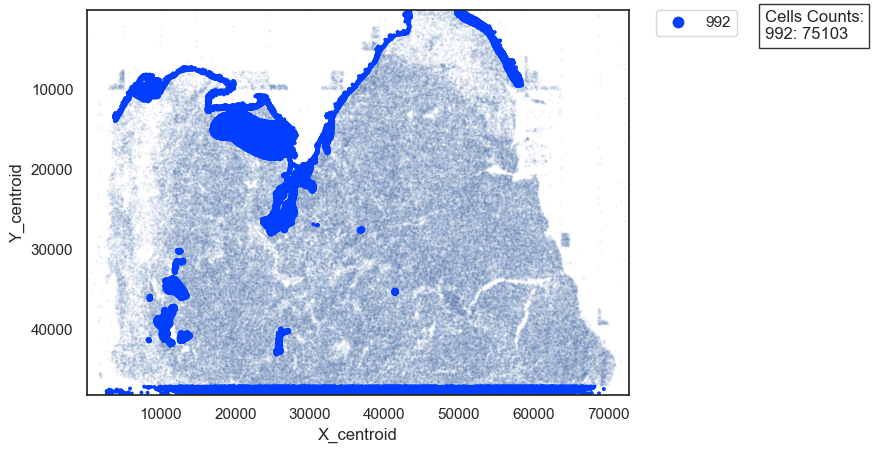

In [7]:
adata = opendvp.filtering.filter_by_annotation(adata, path_to_artefact_annotations)

In [8]:
from opendvp.anndata_utils import save_adata_checkpoint
save_adata_checkpoint(adata=adata, path_to_dir=path_to_backup, checkpoint_name="1_annotation_filter")

2025-03-02 18:43:59.199 | INFO     | opendvp.anndata_utils:save_adata_checkpoint:73 - Writing h5ad
2025-03-02 18:43:59.604 | SUCCESS  | opendvp.anndata_utils:save_adata_checkpoint:75 - Wrote h5ad file
2025-03-02 18:43:59.605 | INFO     | opendvp.anndata_utils:save_adata_checkpoint:82 - Writing parquet
2025-03-02 18:44:00.707 | SUCCESS  | opendvp.anndata_utils:save_adata_checkpoint:84 - Wrote parquet file


## Step 1.2: Remove 'cells' with too low DAPI

In [2]:
adata = ad.read_h5ad("../data/perSample/992/adata_checkpoints/1_annotation_filter/20250302_1843_1_annotation_filter_adata.h5ad")

/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/.pixi/envs/default/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning:

Transforming to str index.



/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/.pixi/envs/default/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning:

divide by zero encountered in log10



Threshold for DAPI intensity: 199.53
Threshold for DAPI intensity: 2818.38


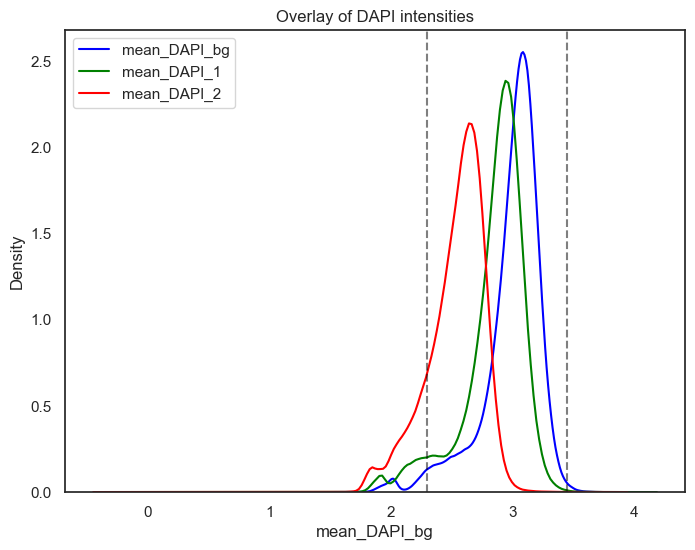

In [3]:
# Plot the density plot for each column
plt.figure(figsize=(8,6))
tmp_df = np.log10(pd.DataFrame(adata.X, columns=adata.var_names))
sns.kdeplot(tmp_df['mean_DAPI_bg'], label='mean_DAPI_bg', color='blue')
sns.kdeplot(tmp_df['mean_DAPI_1'], label='mean_DAPI_1', color='green')
sns.kdeplot(tmp_df['mean_DAPI_2'], label='mean_DAPI_2', color='red')

low_threshold = 2.3
plt.axvline(low_threshold, color='black', linestyle='--', alpha=0.5)
print(f"Threshold for DAPI intensity: {10**low_threshold:.2f}")

high_threshold = 3.45
plt.axvline(high_threshold, color='black', linestyle='--', alpha=0.5)
print(f"Threshold for DAPI intensity: {10**high_threshold:.2f}")

plt.title('Overlay of DAPI intensities')
plt.legend()
plt.show()

In [6]:
adata = opendvp.filtering.filter_by_abs_value(adata=adata, marker="mean_DAPI_bg", value=199, keep="above")
adata = opendvp.filtering.filter_by_abs_value(adata=adata, marker="mean_DAPI_bg", value=2818, keep="below")

2025-03-03 10:40:17.854 | INFO     | opendvp.filtering:filter_by_abs_value:39 -  ---- filter_by_abs_value : version number 1.1.0 ----
2025-03-03 10:40:18.075 | INFO     | opendvp.filtering:filter_by_abs_value:73 - Number of cells with mean_DAPI_bg above 199: 1107908
2025-03-03 10:40:18.075 | INFO     | opendvp.filtering:filter_by_abs_value:88 -  ---- filter_by_abs_value is done, took 0s  ----
2025-03-03 10:40:18.085 | INFO     | opendvp.filtering:filter_by_abs_value:39 -  ---- filter_by_abs_value : version number 1.1.0 ----
2025-03-03 10:40:18.223 | INFO     | opendvp.filtering:filter_by_abs_value:73 - Number of cells with mean_DAPI_bg below 2818: 1131162
2025-03-03 10:40:18.224 | INFO     | opendvp.filtering:filter_by_abs_value:88 -  ---- filter_by_abs_value is done, took 0s  ----


In [10]:
opendvp.anndata_utils.save_adata_checkpoint(adata,path_to_dir=path_to_backup, checkpoint_name="2_abs_DAPI_filter")

2025-03-03 10:41:00.767 | INFO     | opendvp.anndata_utils:save_adata_checkpoint:73 - Writing h5ad
2025-03-03 10:41:01.154 | SUCCESS  | opendvp.anndata_utils:save_adata_checkpoint:75 - Wrote h5ad file
2025-03-03 10:41:01.154 | INFO     | opendvp.anndata_utils:save_adata_checkpoint:82 - Writing parquet
2025-03-03 10:41:02.620 | SUCCESS  | opendvp.anndata_utils:save_adata_checkpoint:84 - Wrote parquet file


## Step 1.3: Remove cells that are too small or too big

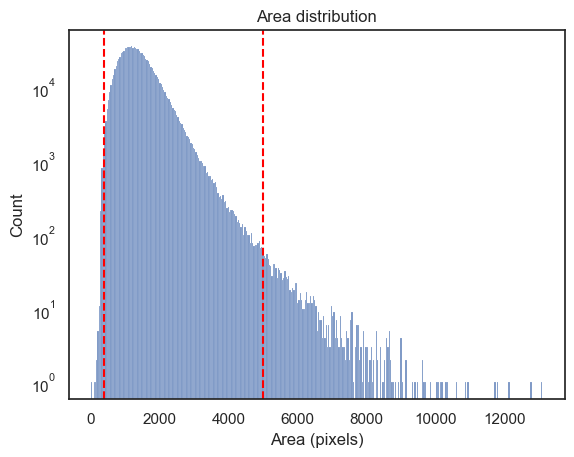

In [12]:
sns.histplot(adata.obs['Area'], bins=350)
plt.yscale('log')
# plt.xscale('log')
plt.title('Area distribution')
plt.xlabel('Area (pixels)')
plt.axvline(400, color='red', linestyle='--')
plt.axvline(5000, color='red', linestyle='--')
plt.show()

In [13]:
adata.obs['Area_filter_nottoobig'] = adata.obs['Area'] < 5000
adata.obs['Area_filter_nottoolow'] = adata.obs['Area'] > 400
adata.obs['Area_filter'] = adata.obs['Area_filter_nottoobig'] & adata.obs['Area_filter_nottoolow']

#print stats
print("Number of cells before filtering: ", adata.shape[0])
print("Number of cells filtered out by Area: ", adata.shape[0] - adata.obs['Area_filter'].sum())
print("Percentage of cells filtered out by Area: ", round((adata.shape[0] - adata.obs['Area_filter'].sum())/adata.shape[0]*100, 3), "%")

Number of cells before filtering:  1134347
Number of cells filtered out by Area:  4417
Percentage of cells filtered out by Area:  0.389 %


In [15]:
opendvp.anndata_utils.save_adata_checkpoint(adata,path_to_backup, checkpoint_name="3_area_filter")

2025-03-03 10:42:41.476 | INFO     | opendvp.anndata_utils:save_adata_checkpoint:73 - Writing h5ad
2025-03-03 10:42:41.911 | SUCCESS  | opendvp.anndata_utils:save_adata_checkpoint:75 - Wrote h5ad file
2025-03-03 10:42:41.912 | INFO     | opendvp.anndata_utils:save_adata_checkpoint:82 - Writing parquet
2025-03-03 10:42:43.206 | SUCCESS  | opendvp.anndata_utils:save_adata_checkpoint:84 - Wrote parquet file


##  Step 1.4: Remove dropout cells by DAPI ratio

2025-03-03 10:59:35.484 | INFO     | opendvp.filtering:filter_by_ratio:94 -  ---- filter_by_ratio : version number 1.1.0 ----
2025-03-03 10:59:35.661 | INFO     | opendvp.filtering:filter_by_ratio:112 - Number of cells with DAPI ratio < 0.15: 36285
2025-03-03 10:59:35.696 | INFO     | opendvp.filtering:filter_by_ratio:113 - Number of cells with DAPI ratio > 1.05: 1618
2025-03-03 10:59:35.731 | INFO     | opendvp.filtering:filter_by_ratio:114 - Number of cells with DAPI ratio between 0.15 and 1.05: 1095999
2025-03-03 10:59:35.766 | INFO     | opendvp.filtering:filter_by_ratio:115 - Percentage of cells filtered out: 3.38%


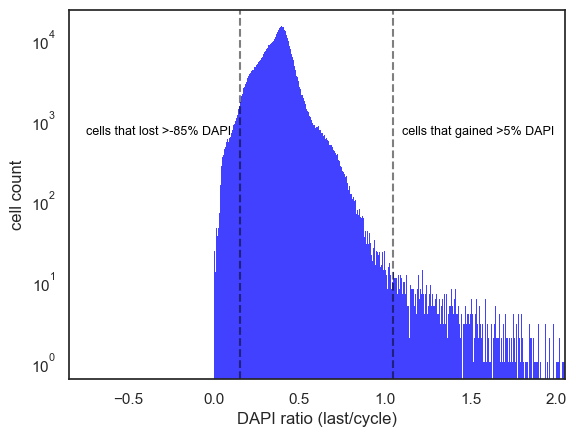

2025-03-03 10:59:37.978 | INFO     | opendvp.filtering:filter_by_ratio:135 -  ---- filter_by_ratio is done, took 2s  ----


In [16]:
adata = opendvp.filtering.filter_by_ratio(
    adata=adata, 
    end_cycle="mean_DAPI_2", 
    start_cycle="mean_DAPI_bg", 
    label="DAPI",
    min_ratio=0.15,
    max_ratio=1.05,
    )

In [18]:
opendvp.anndata_utils.save_adata_checkpoint(adata,path_to_dir=path_to_backup,checkpoint_name="4_dropout_cells_filter")

2025-03-03 11:00:11.136 | INFO     | opendvp.anndata_utils:save_adata_checkpoint:73 - Writing h5ad
2025-03-03 11:00:11.548 | SUCCESS  | opendvp.anndata_utils:save_adata_checkpoint:75 - Wrote h5ad file
2025-03-03 11:00:11.548 | INFO     | opendvp.anndata_utils:save_adata_checkpoint:82 - Writing parquet
2025-03-03 11:00:12.842 | SUCCESS  | opendvp.anndata_utils:save_adata_checkpoint:84 - Wrote parquet file


## Step 1.5: Quality control

In [20]:
adata.obs.columns

Index(['CellID', 'Y_centroid', 'X_centroid', 'Area', 'MajorAxisLength',
       'MinorAxisLength', 'Eccentricity', 'Orientation', 'Extent', 'Solidity',
       '992', 'artefact', 'mean_DAPI_bg_above_199', 'mean_DAPI_bg_below_2818',
       'Area_filter_nottoobig', 'Area_filter_nottoolow', 'Area_filter',
       'DAPI_ratio', 'DAPI_ratio_pass_nottoolow', 'DAPI_ratio_pass_nottoohigh',
       'DAPI_ratio_pass'],
      dtype='object')

In [21]:
condition = (~adata.obs['artefact'].astype(bool) & 
            adata.obs['mean_DAPI_bg_above_199'] & 
            adata.obs['mean_DAPI_bg_below_2818'] & 
            adata.obs['Area_filter'] & 
            adata.obs['DAPI_ratio_pass'])

In [22]:
adata.obs['filtering'] = condition.values

In [23]:
print(adata.shape)
adata = adata[adata.obs['filtering']==True]
print(adata.shape)

(1134347, 75)
(1005051, 75)


In [25]:
opendvp.anndata_utils.save_adata_checkpoint(adata=adata, path_to_dir=path_to_backup, checkpoint_name="5_filtering_done")

2025-03-03 11:01:28.185 | INFO     | opendvp.anndata_utils:save_adata_checkpoint:73 - Writing h5ad
2025-03-03 11:01:28.729 | SUCCESS  | opendvp.anndata_utils:save_adata_checkpoint:75 - Wrote h5ad file
2025-03-03 11:01:28.730 | INFO     | opendvp.anndata_utils:save_adata_checkpoint:82 - Writing parquet
2025-03-03 11:01:29.944 | SUCCESS  | opendvp.anndata_utils:save_adata_checkpoint:84 - Wrote parquet file


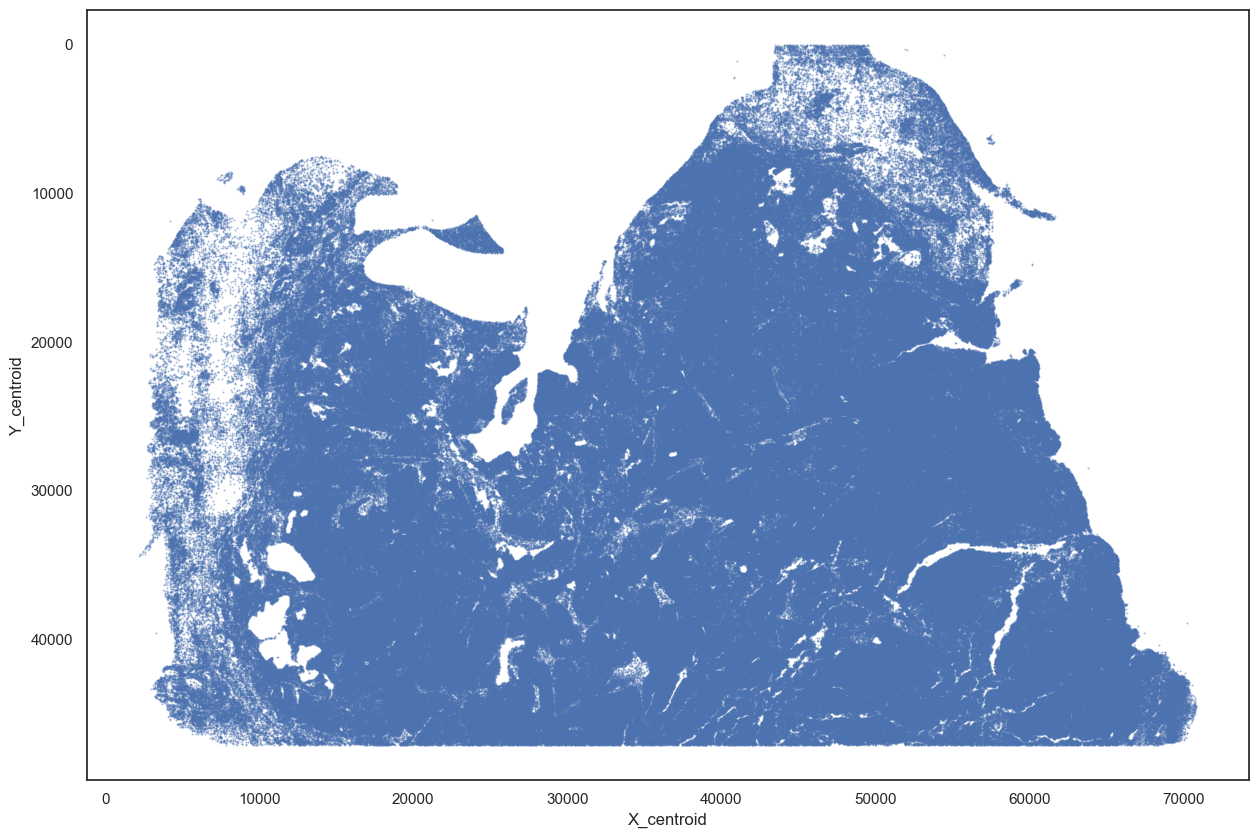

In [26]:
sns.scatterplot(data=adata.obs, x='X_centroid', y='Y_centroid', linewidth=0, s=2, alpha=0.5)
fig = plt.gcf()
fig.set_size_inches(15, 10)
#flip y axis
plt.gca().invert_yaxis()
plt.show()

# Step 2: Phenotyping

In [29]:
gates = opendvp.phenotyping.read_gates(path_to_gates, sample_id=992)
gates_processed = opendvp.phenotyping.process_gates_for_sm(gates, sample_id=992)

2025-03-03 11:07:32.735 | INFO     | opendvp.phenotyping:read_gates:12 -  ---- read_gates : version number 1.1.0 ----
2025-03-03 11:07:32.746 | INFO     | opendvp.phenotyping:read_gates:18 -    Filtering out all rows with value 0.0 (assuming not gated)
2025-03-03 11:07:32.747 | INFO     | opendvp.phenotyping:read_gates:21 -   Found 8 valid gates
2025-03-03 11:07:32.748 | INFO     | opendvp.phenotyping:read_gates:22 -   Markers found: ['mean_Vimentin' 'mean_CD3e' 'mean_panCK' 'mean_COL1A1' 'mean_CD20'
 'mean_CD68' 'mean_Ki67' 'mean_CD8']
2025-03-03 11:07:32.749 | INFO     | opendvp.phenotyping:read_gates:23 -   Samples found: [992]
2025-03-03 11:07:32.749 | INFO     | opendvp.phenotyping:read_gates:28 -   Found 8 valid gates for sample 992
2025-03-03 11:07:32.750 | INFO     | opendvp.phenotyping:read_gates:30 -  ---- read_gates is done, took 0s  ----
2025-03-03 11:07:32.750 | INFO     | opendvp.phenotyping:process_gates_for_sm:35 -  ---- process_gates_for_sm : version number 1.2.0 ----


In [31]:
adata_pheno = adata[:, adata.var_names.isin(gates_processed['markers'])].copy()
adata_pheno.obs['imageid'] = 992
adata_pheno.raw = adata_pheno
sm.pp.log1p(adata_pheno)
adata_pheno = sm.pp.rescale(adata_pheno, gate=gates_processed, log=True, verbose=True)

/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/.pixi/envs/default/lib/python3.11/site-packages/scimap/preprocessing/rescale.py:145: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`




Scaling Image: 992
Scaling mean_Vimentin (gate: 5.449)
Scaling mean_CD3e (gate: 5.861)
Scaling mean_panCK (gate: 5.421)
Scaling mean_CD8 (gate: 7.752)
Scaling mean_COL1A1 (gate: 6.649)
Scaling mean_CD20 (gate: 6.312)
Scaling mean_CD68 (gate: 5.525)
Scaling mean_Ki67 (gate: 2.554)


In [32]:
sm.tl.phenotype_cells (adata_pheno, phenotype=pd.read_csv(path_to_phenotype_matrix), label="phenotype")

Phenotyping Cancer_cells
Phenotyping T_cells
Phenotyping Vimentin_cells
Phenotyping COL1A1_cells
Phenotyping B_cells
Phenotyping Macrophages
-- Subsetting T_cells
Phenotyping CD4_Tcells
Phenotyping CD8_Tcells
Consolidating the phenotypes across all groups


/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/.pixi/envs/default/lib/python3.11/site-packages/scimap/tools/phenotype_cells.py:290: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/.pixi/envs/default/lib/python3.11/site-packages/scimap/tools/phenotype_cells.py:290: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



AnnData object with n_obs × n_vars = 1005051 × 8
    obs: 'CellID', 'Y_centroid', 'X_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Orientation', 'Extent', 'Solidity', '992', 'artefact', 'mean_DAPI_bg_above_199', 'mean_DAPI_bg_below_2818', 'Area_filter_nottoobig', 'Area_filter_nottoolow', 'Area_filter', 'DAPI_ratio', 'DAPI_ratio_pass_nottoolow', 'DAPI_ratio_pass_nottoohigh', 'DAPI_ratio_pass', 'filtering', 'imageid', 'phenotype'
    var: 'math', 'marker'
    uns: 'gates'
    layers: 'log'

In [33]:
adata.obs['phenotype'] = adata_pheno.obs['phenotype'].copy()
adata.obs['imageid'] = 991
adata.uns['gates'] = adata_pheno.uns['gates'].copy()
adata.uns['gates'].columns = [str(col) for col in adata.uns['gates'].columns]
adata.uns['X_log1p'] = adata_pheno.layers['log']
adata.uns['X_scaled_pheno'] = adata_pheno.X.copy()

/var/folders/x7/grkjlk8s223dy6234rnz1885mxz2_6/T/ipykernel_9246/3601950691.py:1: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



In [34]:
adata_pheno.uns['gates'].columns = [str(col) for col in adata_pheno.uns['gates'].columns]

In [36]:
opendvp.anndata_utils.save_adata_checkpoint(adata=adata, path_to_dir=path_to_backup, checkpoint_name="6_phenotyped")
opendvp.anndata_utils.save_adata_checkpoint(adata=adata_pheno, path_to_dir=path_to_backup, checkpoint_name="7_adata_pheno")

2025-03-03 11:12:55.228 | INFO     | opendvp.anndata_utils:save_adata_checkpoint:73 - Writing h5ad
2025-03-03 11:12:55.768 | SUCCESS  | opendvp.anndata_utils:save_adata_checkpoint:75 - Wrote h5ad file
2025-03-03 11:12:55.769 | INFO     | opendvp.anndata_utils:save_adata_checkpoint:82 - Writing parquet
2025-03-03 11:12:56.855 | SUCCESS  | opendvp.anndata_utils:save_adata_checkpoint:84 - Wrote parquet file
2025-03-03 11:12:56.856 | INFO     | opendvp.anndata_utils:save_adata_checkpoint:73 - Writing h5ad
2025-03-03 11:12:57.241 | SUCCESS  | opendvp.anndata_utils:save_adata_checkpoint:75 - Wrote h5ad file
2025-03-03 11:12:57.242 | INFO     | opendvp.anndata_utils:save_adata_checkpoint:82 - Writing parquet
2025-03-03 11:12:57.406 | SUCCESS  | opendvp.anndata_utils:save_adata_checkpoint:84 - Wrote parquet file


# Step 3: Describe phenotyping

In [3]:
adata = ad.read_h5ad("../data/perSample/992/adata_checkpoints/7_adata_pheno/20250303_1112_7_adata_pheno_adata.h5ad")
adata

AnnData object with n_obs × n_vars = 1005051 × 8
    obs: 'CellID', 'Y_centroid', 'X_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Orientation', 'Extent', 'Solidity', '992', 'artefact', 'mean_DAPI_bg_above_199', 'mean_DAPI_bg_below_2818', 'Area_filter_nottoobig', 'Area_filter_nottoolow', 'Area_filter', 'DAPI_ratio', 'DAPI_ratio_pass_nottoolow', 'DAPI_ratio_pass_nottoohigh', 'DAPI_ratio_pass', 'filtering', 'imageid', 'phenotype'
    var: 'math', 'marker'
    uns: 'gates'
    layers: 'log'

In [4]:
#load mask
image = skimage.io.imread("/Volumes/Extreme SSD/P26_BCCN/P26E07_E08_E09_SOPA_Gates/expanded-masks/992.tif")
logger.info("mask loaded into memory")
image = image.astype(np.int32)
logger.info("data type changed to int32")
gdf = imaging.mask_to_polygons(image)
logger.info("mask converted to polygons")

2025-04-09 16:09:55.102 | INFO     | __main__:<module>:3 - mask loaded into memory
2025-04-09 16:10:01.460 | INFO     | __main__:<module>:5 - data type changed to int32
2025-04-09 16:13:09.757 | INFO     | __main__:<module>:7 - mask converted to polygons


In [20]:
np.iinfo(np.int32).max

2147483647

In [9]:
gdf.sort_values(by="cellId")

,cellId,geometry
523104,1,"MULTIPOLYGON (((37137 29400, 37137 29402, 3713..."
524001,2,"POLYGON ((38263 29397, 38263 29398, 38262 2939..."
526597,3,"POLYGON ((39181 29447, 39181 29448, 39175 2944..."
527404,4,"POLYGON ((37365 29506, 37365 29507, 37364 2950..."
537088,5,"POLYGON ((36850 29805, 36850 29806, 36847 2980..."
...,...,...
459163,1134343,"POLYGON ((37572 27251, 37572 27252, 37571 2725..."
459340,1134344,"POLYGON ((38997 27251, 38997 27253, 38996 2725..."
459403,1134345,"POLYGON ((37417 27247, 37417 27248, 37416 2724..."
459256,1134346,"POLYGON ((38234 27253, 38234 27254, 38233 2725..."


In [5]:
#load color_dict
with open("../assets/pheno_colors.json", "r") as f:
    loaded_dict = json.load(f)

In [21]:
anndata_utils.color_geojson_w_adata(
    geodataframe = gdf,
    geodataframe_index_key = None,
    adata=adata,
    adata_obs_index_key="CellID",
    adata_obs_category_key="phenotype",
    color_dict = loaded_dict,
    export_path = "../data/perSample/992/qc/20250409_991_pheno_mask.geojson"
)

2025-04-09 16:54:46.483 | INFO     | opendvp.anndata_utils:color_geojson_w_adata:114 - geodataframe index key not passed, using index
/Users/jnimoca/Jose_BI/1_Pipelines/openDVP/src/opendvp/anndata_utils.py:122: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  gdf['class'] = gdf['class'].replace("nan", "filtered_out")
2025-04-09 16:54:46.871 | INFO     | opendvp.anndata_utils:color_geojson_w_adata:126 - Using color_dict found in table.uns[{'B_cells': '#ff7df3', 'CD4_Tcells': '#6efa6e', 'CD8_Tcells': '#2020d8', 'Cancer_cells': '#f55148', 'Vimentin_cells': '#866a21', 'Macrophages': '#ffff00', 'COL1A1_cells': '#ff7f0e', 'Unknown': '#7f7f7f'}]
2025-04-09 16:54:51.659 | INFO     | opendvp.anndata_utils:color_geojson_w_adata:141 - Simplifying the geometry with tolerance 1


In [ ]:
def color_geojson_w_adata(
        geodataframe,
        geodataframe_index_key,
        adata,
        adata_obs_index_key,
        adata_obs_category_key,
        color_dict,
        export_path,
        simplify_value=1,
        return_gdf=False
):
    
    gdf = geodataframe.copy()
    gdf['objectType'] = "detection"

    phenotypes_series = adata.obs.set_index(adata_obs_index_key)[adata_obs_category_key]
    
    if geodataframe_index_key:
        gdf[geodataframe_index_key] = gdf[geodataframe_index_key].astype(str)
        gdf['class'] = gdf[geodataframe_index_key].map(phenotypes_series).astype(str)
    else:
        logger.info("geodataframe index key not passed, using index")
        gdf.index = gdf.index.astype(str)
        gdf['class'] = gdf.index.map(phenotypes_series).astype(str)

    gdf['class'] = gdf['class'].astype("category")
    gdf['class'] = gdf['class'].cat.add_categories('filtered_out') 
    # impute nan or np.NaN to filtered_out
    gdf['class'] = gdf['class'].fillna('filtered_out')
    gdf['class'] = gdf['class'].replace("nan", "filtered_out")


    if color_dict:
            logger.info(f"Using color_dict found in table.uns[{color_dict}]")
            color_dict = parse_color_for_qupath(color_dict)
    else:
            logger.info("No color_dict found, using defaults")
            default_colors = [[31, 119, 180], [255, 127, 14], [44, 160, 44], [214, 39, 40], [148, 103, 189]]
            color_cycle = cycle(default_colors)
            color_dict = dict(zip(adata.obs[adata_obs_category_key].cat.categories.astype(str), color_cycle))

    if 'filtered_out' not in color_dict:
        color_dict['filtered_out'] = [0,0,0]

    gdf['classification'] = gdf.apply(lambda x: {'name': x['class'], 'color': color_dict[x['class']]}, axis=1)
    gdf.drop(columns='class', inplace=True)

    #simplify the geometry
    logger.info(f"Simplifying the geometry with tolerance {simplify_value}")
    gdf['geometry'] = gdf['geometry'].simplify(simplify_value, preserve_topology=True)

    gdf.to_file(export_path, driver='GeoJSON')

    if return_gdf:
        return gdf
    
def parse_color_for_qupath(color_dict):
    parsed_colors = {}
    for name, color in color_dict.items():
        if isinstance(color, tuple) and len(color) == 3:
            # Handle RGB fraction tuples (0-1)
            parsed_colors[name] = list(int(c * 255) for c in color)
        elif isinstance(color, str) and re.match(r'^#(?:[0-9a-fA-F]{3}){1,2}$', color):
            # Handle hex codes
            parsed_colors[name] = mcolors.hex2color(color)
            parsed_colors[name] = list(int(c * 255) for c in parsed_colors[name])
        else:
            raise ValueError(f"Invalid color format for '{name}': {color}")
        
    return parsed_colors

In [10]:
gdf['objectType'] = "detection"
gdf.head()

,cellId,geometry,objectType
0,202520,"POLYGON ((68595 0, 68595 20, 68596 20, 68596 2...",detection
1,202521,"POLYGON ((71124 0, 71124 1, 71123 1, 71123 3, ...",detection
2,906503,"POLYGON ((44292 12, 44292 13, 44289 13, 44289 ...",detection
3,202522,"POLYGON ((72803 0, 72803 3, 72802 3, 72802 12,...",detection
4,207429,"POLYGON ((43404 9, 43404 10, 43401 10, 43401 1...",detection


In [23]:
gdf

,cellId,geometry,objectType,class
0,202520,"POLYGON ((68595 0, 68595 20, 68596 20, 68596 2...",detection,nan
1,202521,"POLYGON ((71124 0, 71124 1, 71123 1, 71123 3, ...",detection,nan
2,906503,"POLYGON ((44292 12, 44292 13, 44289 13, 44289 ...",detection,nan
3,202522,"POLYGON ((72803 0, 72803 3, 72802 3, 72802 12,...",detection,nan
4,207429,"POLYGON ((43404 9, 43404 10, 43401 10, 43401 1...",detection,nan
...,...,...,...,...
1134342,140705,"POLYGON ((64083 48111, 64083 48112, 64080 4811...",detection,nan
1134343,298936,"POLYGON ((63613 48117, 63613 48118, 63610 4811...",detection,nan
1134344,140727,"POLYGON ((63733 48125, 63733 48126, 63730 4812...",detection,nan
1134345,140716,"POLYGON ((63914 48120, 63914 48121, 63911 4812...",detection,nan


In [24]:
gdf.dtypes

cellId          object
geometry      geometry
objectType      object
class           object
dtype: object

In [26]:
gdf['cellId'] = gdf['cellId'].astype('int32')

In [27]:
gdf.sort_values(by="cellId").head(10)

,cellId,geometry,objectType,class
523104,1,"MULTIPOLYGON (((37137 29400, 37137 29402, 3713...",detection,nan
524001,2,"POLYGON ((38263 29397, 38263 29398, 38262 2939...",detection,nan
526597,3,"POLYGON ((39181 29447, 39181 29448, 39175 2944...",detection,nan
527404,4,"POLYGON ((37365 29506, 37365 29507, 37364 2950...",detection,nan
537088,5,"POLYGON ((36850 29805, 36850 29806, 36847 2980...",detection,nan
653728,6,"POLYGON ((35597 33648, 35597 33649, 35596 3364...",detection,nan
340903,7,"POLYGON ((44393 23196, 44393 23197, 44390 2319...",detection,nan
458856,8,"POLYGON ((37077 27249, 37077 27250, 37074 2725...",detection,nan
458961,9,"POLYGON ((37361 27252, 37361 27253, 37360 2725...",detection,nan
459259,10,"POLYGON ((37956 27251, 37956 27252, 37953 2725...",detection,nan


In [28]:
gdf.cellId.nunique()

1134347

In [29]:
phenotypes_series = adata.obs.set_index("CellID")["phenotype"]

In [30]:
phenotypes_series

CellID
2          Cancer_cells
3          Cancer_cells
4            CD8_Tcells
5          Cancer_cells
6          Cancer_cells
               ...     
1134343         Unknown
1134344    Cancer_cells
1134345    Cancer_cells
1134346    Cancer_cells
1134347    Cancer_cells
Name: phenotype, Length: 1005051, dtype: category
Categories (8, object): ['B_cells', 'CD4_Tcells', 'CD8_Tcells', 'COL1A1_cells', 'Cancer_cells', 'Macrophages', 'Unknown', 'Vimentin_cells']

In [ ]:
phenotypes_series

In [ ]:
gdf[geodataframe_index_key] = gdf[geodataframe_index_key].astype(str)

In [13]:
geodataframe_index_key = "cellId"

if geodataframe_index_key:
    gdf[geodataframe_index_key] = gdf[geodataframe_index_key].astype(str)
    gdf['class'] = gdf[geodataframe_index_key].map(phenotypes_series).astype(str)
else:
    logger.info("geodataframe index key not passed, using index")
    gdf.index = gdf.index.astype(str)
    gdf['class'] = gdf.index.map(phenotypes_series).astype(str)

In [14]:
gdf

,cellId,geometry,objectType,class
0,202520,"POLYGON ((68595 0, 68595 20, 68596 20, 68596 2...",detection,nan
1,202521,"POLYGON ((71124 0, 71124 1, 71123 1, 71123 3, ...",detection,nan
2,906503,"POLYGON ((44292 12, 44292 13, 44289 13, 44289 ...",detection,nan
3,202522,"POLYGON ((72803 0, 72803 3, 72802 3, 72802 12,...",detection,nan
4,207429,"POLYGON ((43404 9, 43404 10, 43401 10, 43401 1...",detection,nan
...,...,...,...,...
1134342,140705,"POLYGON ((64083 48111, 64083 48112, 64080 4811...",detection,nan
1134343,298936,"POLYGON ((63613 48117, 63613 48118, 63610 4811...",detection,nan
1134344,140727,"POLYGON ((63733 48125, 63733 48126, 63730 4812...",detection,nan
1134345,140716,"POLYGON ((63914 48120, 63914 48121, 63911 4812...",detection,nan


# 10.04.2025 Export phenotypes to geojsons

Since functions have now been improved and tested, we can now export phenotypes using the mask and processed adata

In [2]:
from opendvp.imaging import mask_to_polygons

In [4]:
gdf = mask_to_polygons(
    mask_path = "/Volumes/Extreme SSD/P26_BCCN/P26E07_E08_E09_SOPA_Gates/expanded-masks/992.tif",
    savepath = "../data/perSample/992/qc/20250410_992_segmentation_as_polygons.geojson",
    simplify = 1
)

2025-04-10 09:08:32.635 | INFO     | opendvp.imaging:mask_to_polygons:157 -  -- Convering /Volumes/Extreme SSD/P26_BCCN/P26E07_E08_E09_SOPA_Gates/expanded-masks/992.tif to geodataframe of polygons -- 
2025-04-10 09:08:33.701 | INFO     | opendvp.imaging:mask_to_polygons:165 -   Mask shape: (1, 48157, 73093), dtype: uint32, estimated_mb: 13427.5
2025-04-10 09:08:51.168 | DEBUG    | opendvp.imaging:mask_to_polygons:177 - Calculated max pixel value in 3.2 seconds
2025-04-10 09:11:59.018 | INFO     | opendvp.imaging:mask_to_polygons:195 - Transformed pixel mask into polygons in 182.4 seconds
2025-04-10 09:12:00.375 | INFO     | opendvp.imaging:mask_to_polygons:207 - Simplifying the geometry with tolerance 1
2025-04-10 09:13:53.082 | INFO     | opendvp.imaging:mask_to_polygons:211 - Writing geodataframe as GeoJSON here ../data/perSample/992/qc/20250410_992_segmentation_as_polygons.geojson
2025-04-10 09:14:23.322 | INFO     | opendvp.imaging:mask_to_polygons:214 - Writing of file took 30.2 s

In [5]:
path_to_adata = "/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/data/perSample/992/adata_checkpoints/7_adata_pheno/20250303_1112_7_adata_pheno_adata.h5ad"
adata = ad.read_h5ad(path_to_adata)

path_to_json = "/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/assets/pheno_colors.json"
with open(path_to_json) as f:
    pheno_colors = json.load(f)

In [6]:
anndata_utils.color_geojson_w_adata(
    geodataframe = gdf,
    geodataframe_index_key="cellId",
    adata=adata,
    adata_obs_index_key="CellID",
    adata_obs_category_key="phenotype",
    color_dict=pheno_colors,
    export_path="/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/data/perSample/992/qc/20250409_992_color_pheno.geojson",
    simplify_value=None, #since we did that above already 
    return_gdf=False
)

2025-04-10 09:16:00.326 | INFO     | opendvp.anndata_utils:color_geojson_w_adata:145 -  -- Adding color to polygons for QuPath visualization -- 
2025-04-10 09:16:00.402 | INFO     | opendvp.anndata_utils:color_geojson_w_adata:158 - Matching gdf[cellId] to adata.obs[CellID]
2025-04-10 09:16:00.436 | INFO     | opendvp.anndata_utils:color_geojson_w_adata:171 - Using color_dict found in table.uns[{'B_cells': '#ff7df3', 'CD4_Tcells': '#6efa6e', 'CD8_Tcells': '#2020d8', 'Cancer_cells': '#f55148', 'Vimentin_cells': '#866a21', 'Macrophages': '#ffff00', 'COL1A1_cells': '#ff7f0e', 'Unknown': '#7f7f7f'}]
2025-04-10 09:16:04.638 | INFO     | opendvp.anndata_utils:color_geojson_w_adata:192 - Writing polygons as geojson file
2025-04-10 09:16:38.424 | INFO     | opendvp.anndata_utils:color_geojson_w_adata:195 - File written in 33.8 seconds


In [7]:
imaging.adataobs_to_voronoi_geojson(
    df=adata.obs,
    imageid=992,
    subset=None,
    category_1 = "phenotype",
    output_path = "/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E10_E11_ImageAnalysis/data/perSample/992/qc/"
)

2025-04-10 09:17:08.308 | DEBUG    | opendvp.imaging:adataobs_to_voronoi_geojson:54 -  df shape: (1005051, 24)
2025-04-10 09:17:08.342 | DEBUG    | opendvp.imaging:adataobs_to_voronoi_geojson:62 -  df shape after imageid subset: (1005051, 24)
2025-04-10 09:17:08.342 | INFO     | opendvp.imaging:adataobs_to_voronoi_geojson:63 - Processing 992, loaded dataframe
2025-04-10 09:17:08.343 | INFO     | opendvp.imaging:adataobs_to_voronoi_geojson:79 - Running Voronoi
2025-04-10 09:17:49.744 | INFO     | opendvp.imaging:adataobs_to_voronoi_geojson:89 - Voronoi done
2025-04-10 09:17:49.795 | INFO     | opendvp.imaging:adataobs_to_voronoi_geojson:93 - Transformed to geodataframe
2025-04-10 09:17:49.799 | INFO     | opendvp.imaging:adataobs_to_voronoi_geojson:101 - Bounding box: x_min: 2216.9608763693273, x_max: 70848.77680906713, y_min: 20.43081312410842, y_max 47084.98548812665
2025-04-10 09:17:57.105 | INFO     | opendvp.imaging:adataobs_to_voronoi_geojson:105 - Filtered out infinite polygons
2